Data Link -> https://datahack.analyticsvidhya.com/contest/linguipedia-codefest-natural-language-processing-1/</br>
**Dataset Description :-**
*For training the models, we provide a labelled dataset of 7920 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.*

**Problem Statement** - Identify Positive/Negative Sentiments from Tweet data.</br>
**ML Problem** - Binary Classification Problem.</br>
**Model Metric** - F1 Score

**Approach :-** :-
- Data Gathering - The dataset is gathered from [here](https://datahack.analyticsvidhya.com/contest/linguipedia-codefest-natural-language-processing-1/).
- Tweet Features have been extracted - count occurences of '!/#/@', count number of negations using nltk, nltk sentiment scores, no. of words/characters, no. of all CAPS words (thought process is it might indicate tweet sentiment).
- Clean data - Tweets are processed by removing hyperlinks, Twitter handles, Lemmatizing words and only keeping words > 2 characters in length.
- Basic EDA - Performed basic EDA - results are available below.
- Vectorize the words - Used Word2Vec to initialize the Embedding layer - Trainable and Non-Trainable models were used while making the Final Predictions.
- 4 Deep Learning models have been used in the final Predictions.
    - Two models used only Text data - W2V vectors used to initialize Embedding layer or Embedding layer used with the Text Sequences and then LSTM layer afterwards.
    - Two models used W2V text vectors to initialize Embedding layer, followed by LSTM layers, then concatenating Tweet features with the Output of the LSTM layer and fed it to the next Dense layer.
- Tried other models and Text Vectorizers but performance is pretty low compared to the DL models.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install gensim
!pip install keras
!pip install wordcloud

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

dir_path = r"/content/gdrive/My Drive/Colab Notebooks/Sentiment Analysis/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

import gensim
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')

from tqdm import tqdm
tqdm.pandas(ncols=70)

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
data = pd.read_csv(dir_path + 'train_data.csv')
data.drop('id', axis=1, inplace=True)
data.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


# Data Exploration

In [0]:
data.label.unique()

array([0, 1])

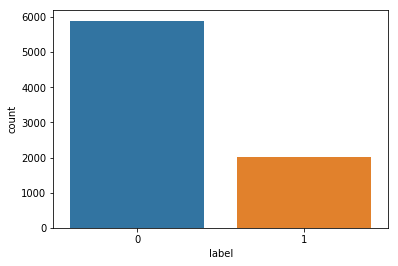

In [0]:
sns.countplot(data['label']);

- The dataset is unbalanced with data belonging to Label '0' is almost 3x that of Label '1'.
- Will use F1 Score metric for model evaluation.

In [0]:
[print(i) for i in data.iloc[:5]['tweet']];

#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


- Two Labels - +ve and -ve.
- 5th Tweet is good - sarcasm!! (Good to Test)
- Maybe remove 1-letter words, remove hashtags and remove duplicates, numbers
- The Hashtags seem to be quite good to infer the Tweet Sentiment.

In [0]:
# Info Seggregation, Data Cleaning and Data Imputation
# 1. Remove special characters and digits - only keep letters.
# 2. Extract contextual links.
# 3. If no hashtags are present in Tweet, then extract adjectives from main sentence and impute.

data['words'] = pd.Series(np.nan)
data['hashtags'] = pd.Series(np.nan)
data['links'] = pd.Series(np.nan)
data['tweet_length'] = pd.Series(np.nan)

def info_extractor(row):
    tweet_sent = []
    hashtags = []
    links = []

    words = row['tweet'].split()
    for word in words:
        if word.startswith('#'):
            temp = re.sub(f'[^{string.ascii_lowercase}]', '', word.lower())
            hashtags.append(temp)
        elif word.startswith('@'):
            continue
        elif ('http' in word) or ('.co' in word) or ('www.' in word):
            temp = word.lower().split('.co')[0]
            temp = temp.split('www.')[-1]
            try:
                temp = temp.split("//")[1].split('/')[0]
            except:
                pass
            links.append(temp)
        else:
            temp = re.sub(f'[^{string.ascii_lowercase}]', '', word.lower())
            if len(temp) > 0:
                tweet_sent.append(temp)
    
    if len(tweet_sent) > 0:
        row['words'] = ' '.join(tweet_sent)
    if len(hashtags) > 0:
        row['hashtags'] = ' '.join(hashtags)
    else:
        row['hashtags'] = ' '.join([word for word,pos in nltk.pos_tag(tweet_sent) if pos.startswith('JJ')])# or pos.startswith('NN')])
    if len(links) > 0:
        row['links'] = ' '.join(links)
        
    row['tweet_length'] = len(row['tweet'])
    
    return row

new_data = data.progress_apply(info_extractor, axis=1)

100%|███████████████████████████| 7920/7920 [00:02<00:00, 2892.11it/s]


In [0]:
new_data.head()

,label,tweet,words,hashtags,links,tweet_length
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,test,fingerprint pregnancy android apps beautiful c...,goo.gl,128
1,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to m...,yay sony xperia s sonyexperias,instagram,131
2,0,We love this! Would you go? #talk #makememorie...,we love this would you go,talk makememories unplug relax iphone smartpho...,fb.me,123
3,0,I'm wired I know I'm George I was made that wa...,im wired i know im george i was made that way,iphone cute daventry home,instagr.am,112
4,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk to m...,amazing i stupid,NaN,124


In [0]:
new_data['words'].isna().sum(), new_data['hashtags'].isna().sum(), new_data['links'].isna().sum() 

(13, 0, 3358)

[]

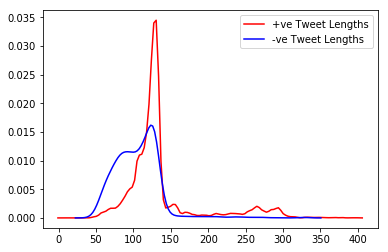

In [0]:
sns.kdeplot(new_data[new_data['label'] == 0].tweet_length, color='red', label='+ve Tweet Lengths')
sns.kdeplot(new_data[new_data['label'] == 1].tweet_length, color='blue', label='-ve Tweet Lengths')
plt.plot()

- The two labels have similar distribution based on the Tweet lengths.

In [0]:
new_data.links.nunique()

386

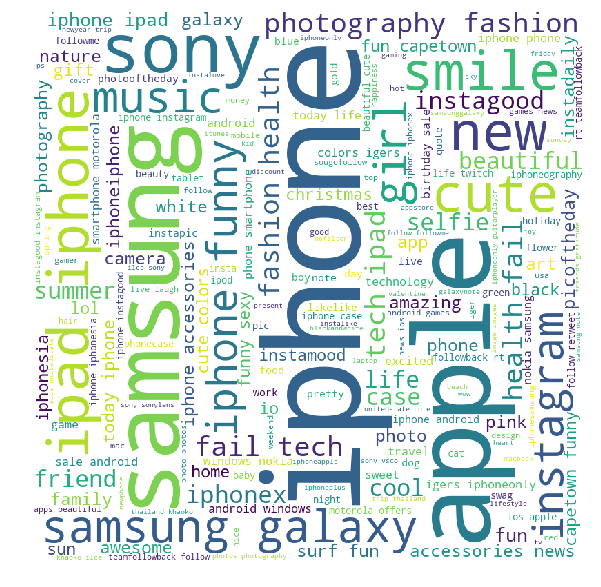

In [0]:
# Popular Hashtags in Positive Labels
hashtags = ''
for tags in new_data[new_data['label'] == 0]['hashtags'].values:
    hashtags += tags

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(hashtags)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
# --> Following code commented out coz some of the output words might be offensive.
# Popular Hashtags in Negative Labels
# hashtags = ''
# for tags in new_data[new_data['label'] == 1]['hashtags'].values:
#     hashtags += tags

# wordcloud = WordCloud(width = 800, height = 800, 
#                 background_color ='white',
#                 min_font_size = 10).generate(hashtags)

# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
  
# plt.show()

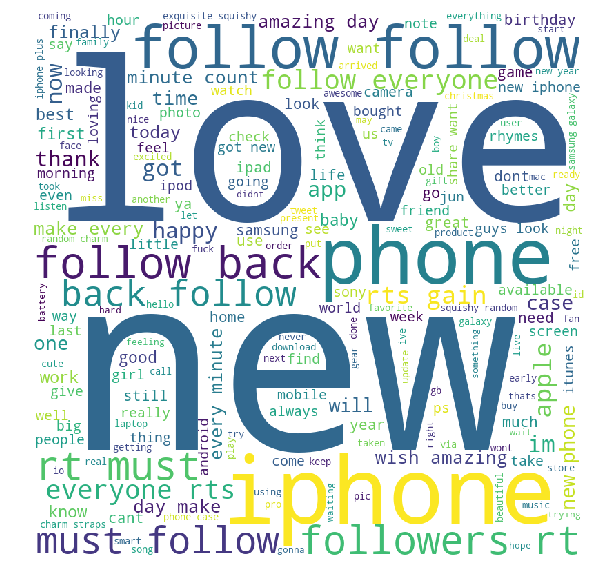

In [0]:
# Popular Words in Positive Labels
words = ''
for tags in new_data[new_data['label'] == 0]['words'].dropna().values:
    words += tags

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
# --> Following code commented out coz some of the output words might be offensive.
# Popular words in Negative Labels
# words = ''
# for tags in new_data[new_data['label'] == 1]['hashtags'].values:
#     words += tags

# wordcloud = WordCloud(width = 800, height = 800, 
#                 background_color ='white',
#                 min_font_size = 10).generate(words)

# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
  
# plt.show()

# Data Cleaning

In [0]:
cleand_tweets = []
stemmer = SnowballStemmer('english')

def info_extractor(row):
    cleaned_tweet = []

    words = row['tweet'].split()
    for word in words:
        # Skip Hyperlinks and Twitter Handles @<user>
#         if ('http' in word) or ('.com' in word) or ('www.' in word) or (word.startswith('@')):
#             continue
        
        # Remove Digits and Special Characters
        temp = re.sub(f'[^{string.ascii_lowercase}]', '', word.lower())
        
        # Remove words with less than 3 characters
#         if len(temp) < 3:
#             continue
            
        # Store the Stemmed version of the word
#         temp = stemmer.stem(temp)
        
        if len(temp) > 0:
            cleaned_tweet.append(temp)

    if len(cleaned_tweet) > 0:
        cleand_tweets.append(' '.join(cleaned_tweet))
    else:
        cleand_tweets.append(np.NaN)
    
    return

data.progress_apply(info_extractor, axis=1);

100%|██████████████████████████| 7920/7920 [00:00<00:00, 17376.84it/s]


In [0]:
df = pd.DataFrame({'label':data.label, 'text':cleand_tweets})
df.head()

,label,text
0,0,fingerprint pregnancy test httpsgooglhmfqv and...
1,0,finally a transparant silicon case thanks to m...
2,0,we love this would you go talk makememories un...
3,0,im wired i know im george i was made that way ...
4,1,what amazing service apple wont even talk to m...


# Model #1 - FastAI Language Model + Classifier

In [0]:
import fastai
from fastai import *
from fastai.text import *

In [0]:
df_train, df_valid = train_test_split(df, stratify=df['label'], train_size=0.8, random_state=42)
df_train.shape, df_valid.shape

((6336, 2), (1584, 2))

In [0]:
def predict_fastai(df_train, df_valid, drop=0.2):
    # Language model data
    data_lm = TextLMDataBunch.from_df(path="", train_df=df_train, valid_df=df_valid)

    # Classifier model data
    data_class = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df=df_valid, vocab=data_lm.train_ds.vocab, bs=32)

    # Create a `Learner` with a language model
    learn = language_model_learner(data=data_lm, arch=AWD_LSTM, drop_mult=drop)

    # train the learner object with learning rate = 1e-2
    learn.fit_one_cycle(1, 1e-2)

    # Save Learned encoder
    learn.save_encoder('ft_enc')

    # Create a `Learner` with a text classifier
    learn = text_classifier_learner(data=data_class, arch=AWD_LSTM, drop_mult=drop)
    learn.load_encoder('ft_enc')

    # Fit a model following the 1cycle policy
    learn.fit_one_cycle(1, 1e-2)

    # get predictions
    preds, targets = learn.get_preds()
    predictions = np.argmax(preds, axis = 1)

    print(pd.crosstab(predictions, targets))
    print()
    print(f'F1 Score: {f1_score(targets, predictions)}')
    
    return (preds.tolist(), predictions.tolist(), targets.tolist())

In [0]:
# Data Frame contains only removed digits and special characters
(fastai_preds, fastai_predictions, fastai_targets) = predict_fastai(df_train, df_valid)

col_0     0    1
row_0           
0      1070   92
1       109  313

F1 Score: 0.7569528415961305


In [0]:
pickle.dump(fastai_preds, open(dir_path + 'fastai_preds', 'wb'))
pickle.dump(fastai_predictions, open(dir_path + 'fastai_predictions', 'wb'))
pickle.dump(fastai_targets, open(dir_path + 'fastai_targets', 'wb'))

In [0]:
fastai_preds = pickle.load(open(dir_path + 'fastai_preds', 'rb'))
fastai_predictions = pickle.load(open(dir_path + 'fastai_predictions', 'rb'))
fastai_targets = pickle.load(open(dir_path + 'fastai_targets', 'rb'))

# Model #2 - LSTM based Network using Embedding Layer

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, GRU
from keras.initializers import Constant
from keras import backend as K
import keras

In [0]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['label'], train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((6336,), (1584,))

In [0]:
# Create a Tokenizer object and fit it on the entire dataset (Train + Test)
# This will contain the vocab space of the dataset
tokenizer = Tokenizer()
total_tweets = df.text
tokenizer.fit_on_texts(total_tweets)

# Calculate Max Seq Length to pad sequences
max_seq_len = max([len(s.split()) for s in total_tweets])

# Define Vocab size
vocab_size = len(tokenizer.word_index) + 1

# Create the sequence of Indices from Text
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make the length equal to max_seq_len
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_seq_len, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_seq_len, padding='post')

In [0]:
# Embedding Layer --> Turns positive integers (indexes) into dense vectors of fixed size.
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_seq_len))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

W0713 10:16:33.620498 140504405157760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 10:16:33.671944 140504405157760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 10:16:33.681445 140504405157760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 10:16:33.807480 140504405157760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0713 10:16:33.820613 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 100)           2154600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,171,657
Trainable params: 2,171,657
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_split=0.3, verbose=1)

Train on 4435 samples, validate on 1901 samples
Epoch 1/25
4435/4435 [==============================] - 6s 1ms/step - loss: 1.0006 - acc: 0.7495 - val_loss: 0.5833 - val_acc: 0.7317
Epoch 2/25
4435/4435 [==============================] - 4s 931us/step - loss: 0.5669 - acc: 0.7495 - val_loss: 0.5824 - val_acc: 0.7317
Epoch 3/25
4435/4435 [==============================] - 4s 924us/step - loss: 0.5641 - acc: 0.7495 - val_loss: 0.5824 - val_acc: 0.7317
Epoch 4/25
4435/4435 [==============================] - 4s 922us/step - loss: 0.5629 - acc: 0.7495 - val_loss: 0.5820 - val_acc: 0.7317
Epoch 5/25
4435/4435 [==============================] - 4s 907us/step - loss: 0.5648 - acc: 0.7495 - val_loss: 0.5828 - val_acc: 0.7317
Epoch 6/25
4435/4435 [==============================] - 4s 923us/step - loss: 0.5648 - acc: 0.7495 - val_loss: 0.5824 - val_acc: 0.7317
Epoch 7/25
4435/4435 [==============================] - 4s 920us/step - loss: 0.5639 - acc: 0.7495 - val_loss: 0.5818 - val_acc: 0.7317
Ep

In [0]:
# Utility Function to get the Best Threshold value
def get_threshold(y_test, preds):
    thresh = 0.3
    max = -1
    for i in np.arange(0.3, 1.0, 0.1):
        score = f1_score(y_test, preds > i)
        print(f'i: {i}, score: {score}')
        if score > max:
            max = score
            thresh = i
    
    thresh = round(thresh, 1)
    print(f'Threshold: {thresh}')
    print('='*70,"\n")
    return thresh

In [0]:
lstm_preds = model.predict(X_test_pad)
lstm_predictions = lstm_preds > get_threshold(y_test, lstm_preds)

print(f'F1 Score: {f1_score(y_test, lstm_predictions)}')
print()
print(confusion_matrix(y_test, lstm_predictions))
print()
print(classification_report(y_test, lstm_predictions))

i: 0.3, score: 0.7769145394006659
i: 0.4, score: 0.7769145394006659
i: 0.5, score: 0.7769145394006659
i: 0.6000000000000001, score: 0.7755555555555556
i: 0.7000000000000002, score: 0.7741935483870968
i: 0.8000000000000003, score: 0.7731843575418995
i: 0.9000000000000001, score: 0.0
Threshold: 0.3

F1 Score: 0.7769145394006659

[[1033  146]
 [  55  350]]

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1179
           1       0.71      0.86      0.78       405

    accuracy                           0.87      1584
   macro avg       0.83      0.87      0.84      1584
weighted avg       0.89      0.87      0.88      1584



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
pickle.dump(lstm_preds, open(dir_path + 'lstm_preds', 'wb'))
pickle.dump(lstm_predictions, open(dir_path + 'lstm_predictions', 'wb'))

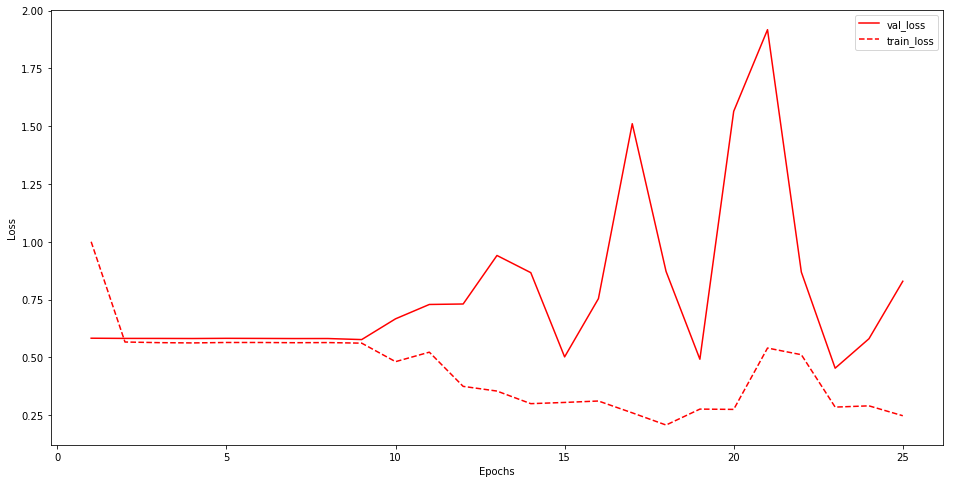

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, 26), history.history['val_loss'], 'r', label='val_loss')
plt.plot(range(1, 26), history.history['loss'], 'r--', label='train_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

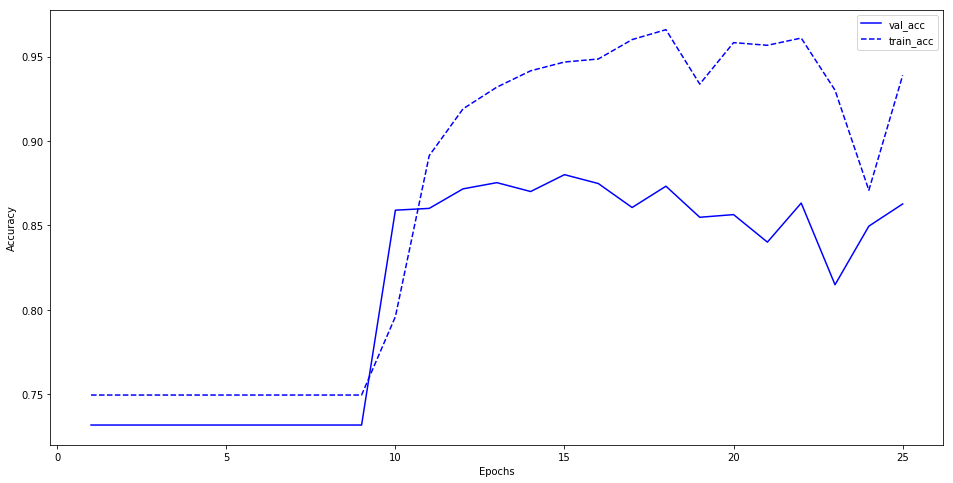

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, 26), history.history['val_acc'], 'b', label='val_acc')
plt.plot(range(1, 26), history.history['acc'], 'b--', label='train_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model #3 with Word2Vec Language Model

In [0]:
tweets = df.text.progress_apply(lambda x: x.split())

100%|█████████████████████████| 7920/7920 [00:00<00:00, 229921.91it/s]


In [0]:
# Train Word2Vec Model
model_w2v = gensim.models.Word2Vec(sentences=tweets, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)

# Vocab list
words = list(model_w2v.wv.vocab)

**Embedding Matrix** - is used to create a relatoinship of the index of a word and the vectorised form of the same, i.e. 'EMBEDDING_DIM' vector using 'Word2Vec' Model as evaluated above. This matrix will be used in the Embedding layer as an initializer. We've set the 'trainable' option to 'False' which indicates the embedding layer weights will not get trained - note "*Non-trainable params: 2,154,600*".

In [0]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i > vocab_size:
        continue
    try:
        embedding_matrix[i] = model_w2v.wv[word]
    except:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

In [0]:
# Embedding Layer --> Turns positive integers (indexes) into dense vectors of fixed size.
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=max_seq_len, trainable=False))
model.add(LSTM(units=32, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(units=16, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52, 100)           2154600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 52, 32)            17024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,174,777
Trainable params: 20,177
Non-trainable params: 2,154,600
_________________________________________________________________


In [0]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_split=0.3, verbose=1)

Train on 4435 samples, validate on 1901 samples
Epoch 1/25
4435/4435 [==============================] - 7s 2ms/step - loss: 0.8928 - acc: 0.7495 - val_loss: 0.7397 - val_acc: 0.7317
Epoch 2/25
4435/4435 [==============================] - 4s 964us/step - loss: 0.6200 - acc: 0.7445 - val_loss: 0.6012 - val_acc: 0.7275
Epoch 3/25
4435/4435 [==============================] - 4s 959us/step - loss: 0.5855 - acc: 0.7421 - val_loss: 0.5900 - val_acc: 0.7301
Epoch 4/25
4435/4435 [==============================] - 4s 965us/step - loss: 0.5600 - acc: 0.7436 - val_loss: 0.5530 - val_acc: 0.7280
Epoch 5/25
4435/4435 [==============================] - 4s 960us/step - loss: 0.5304 - acc: 0.7513 - val_loss: 0.4871 - val_acc: 0.7386
Epoch 6/25
4435/4435 [==============================] - 4s 962us/step - loss: 0.5011 - acc: 0.7664 - val_loss: 0.4249 - val_acc: 0.7796
Epoch 7/25
4435/4435 [==============================] - 4s 968us/step - loss: 0.4674 - acc: 0.7736 - val_loss: 0.3852 - val_acc: 0.8106
Ep

In [0]:
w2v_preds = model.predict(X_test_pad)
w2v_predictions = w2v_preds > get_threshold(y_test, w2v_preds)

print(f'F1 Score: {f1_score(y_test, w2v_predictions)}')
print()
print(confusion_matrix(y_test, w2v_predictions))
print()
print(classification_report(y_test, w2v_predictions))

i: 0.3, score: 0.7088846880907372
i: 0.4, score: 0.7165354330708662
i: 0.5, score: 0.7193347193347193
i: 0.6000000000000001, score: 0.7231121281464531
i: 0.7000000000000002, score: 0.3560606060606061
i: 0.8000000000000003, score: 0.0
i: 0.9000000000000001, score: 0.0
Threshold: 0.6

F1 Score: 0.7231121281464531

[[1026  153]
 [  89  316]]

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1179
           1       0.67      0.78      0.72       405

    accuracy                           0.85      1584
   macro avg       0.80      0.83      0.81      1584
weighted avg       0.86      0.85      0.85      1584



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
pickle.dump(w2v_preds, open(dir_path + 'w2v_preds', 'wb'))
pickle.dump(w2v_predictions, open(dir_path + 'w2v_predictions', 'wb'))

# Model #4 - Logistic Regression with BOW

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [0]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english', ngram_range=(1,3))
bow = bow_vectorizer.fit_transform(data['tweet'])

print(bow.shape)

(7920, 10000)


In [0]:
split = round(0.8*bow.shape[0])
train_bow = bow[:split, :]
test_bow = bow[split:, :]

In [0]:
params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
         }
lr = LogisticRegression()
clf = RandomizedSearchCV(lr, n_iter=20, param_distributions=params, cv=5, verbose=1, n_jobs=-1)
clf.fit(train_bow, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=20, n_jobs=-1,
                   param_distribution...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+0

In [0]:
clf.best_estimator_

LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_preds = clf.best_estimator_.predict_proba(test_bow)
lr_preds = [i[0] for i in lr_preds]
lr_predictions = lr_preds > get_threshold(y_test, lr_preds)

print(f'F1 Score: {f1_score(y_test, lr_predictions)}')
print()
print(confusion_matrix(y_test, lr_predictions))
print()
print(classification_report(y_test, lr_predictions))

i: 0.3, score: 0.4072398190045249
i: 0.4, score: 0.4072398190045249
i: 0.5, score: 0.4072398190045249
i: 0.6000000000000001, score: 0.4072398190045249
i: 0.7000000000000002, score: 0.4072398190045249
i: 0.8000000000000003, score: 0.0
i: 0.9000000000000001, score: 0.0
Threshold: 0.3

F1 Score: 0.4072398190045249

[[   0 1179]
 [   0  405]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1179
           1       0.26      1.00      0.41       405

    accuracy                           0.26      1584
   macro avg       0.13      0.50      0.20      1584
weighted avg       0.07      0.26      0.10      1584



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
pickle.dump(lr_preds, open(dir_path + 'lr_preds', 'wb'))
pickle.dump(lr_predictions, open(dir_path + 'lr_predictions', 'wb'))

# Model #5 - Logistic Regression with TFIDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english', ngram_range=(1,3))
tfidf = tfidf_vectorizer.fit_transform(data['tweet'])

print(tfidf.shape)

(7920, 10000)


In [0]:
split = round(0.8 * tfidf.shape[0])
train_tfidf = tfidf[:split, :]
test_tfidf = tfidf[split:, :]

In [0]:
params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
         }
lr = LogisticRegression()
clf = RandomizedSearchCV(lr, n_iter=20, param_distributions=params, cv=5, n_jobs=-1)
clf.fit(train_tfidf, y_train)

clf.best_estimator_

LogisticRegression(C=0.03359818286283781, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_preds = clf.best_estimator_.predict_proba(test_tfidf)
lr_preds = [i[0] for i in lr_preds]
lr_predictions = lr_preds > get_threshold(y_test, lr_preds)

print(f'F1 Score: {f1_score(y_test, lr_predictions)}')
print()
print(confusion_matrix(y_test, lr_predictions))
print()
print(classification_report(y_test, lr_predictions))

i: 0.3, score: 0.4072398190045249
i: 0.4, score: 0.4072398190045249
i: 0.5, score: 0.4072398190045249
i: 0.6000000000000001, score: 0.4072398190045249
i: 0.7000000000000002, score: 0.4072398190045249
i: 0.8000000000000003, score: 0.0
i: 0.9000000000000001, score: 0.0
Threshold: 0.3

F1 Score: 0.4072398190045249

[[   0 1179]
 [   0  405]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1179
           1       0.26      1.00      0.41       405

    accuracy                           0.26      1584
   macro avg       0.13      0.50      0.20      1584
weighted avg       0.07      0.26      0.10      1584



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
pickle.dump(lr_preds, open(dir_path + 'tfidf_preds', 'wb'))
pickle.dump(lr_predictions, open(dir_path + 'tfidf_predictions', 'wb'))

# Model #6 - Mulitnomial NB with TFIDF

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:
params = {
    'alpha': [0.1, 0.01, 0.001, 0.0001, 1.0, 10.0, 100.0, 1000.0]
         }
nb = MultinomialNB()
clf = GridSearchCV(nb, param_grid=params, cv=5, n_jobs=-1)
clf.fit(train_tfidf, y_train)

clf.best_estimator_

MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True)

In [0]:
nb_preds = clf.best_estimator_.predict_proba(test_tfidf)
nb_preds = [i[0] for i in nb_preds]
nb_predictions = nb_preds > get_threshold(y_test, nb_preds)

print(f'F1 Score: {f1_score(y_test, nb_predictions)}')
print()
print(confusion_matrix(y_test, nb_predictions))
print()
print(classification_report(y_test, nb_predictions))

i: 0.3, score: 0.4072398190045249
i: 0.4, score: 0.4072398190045249
i: 0.5, score: 0.4072398190045249
i: 0.6000000000000001, score: 0.4072398190045249
i: 0.7000000000000002, score: 0.40585562847046946
i: 0.8000000000000003, score: 0.38879551820728286
i: 0.9000000000000001, score: 0.20234604105571846
Threshold: 0.3

F1 Score: 0.4072398190045249

[[   0 1179]
 [   0  405]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1179
           1       0.26      1.00      0.41       405

    accuracy                           0.26      1584
   macro avg       0.13      0.50      0.20      1584
weighted avg       0.07      0.26      0.10      1584



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
pickle.dump(nb_preds, open(dir_path + 'nb_preds', 'wb'))
pickle.dump(nb_predictions, open(dir_path + 'nb_predictions', 'wb'))

# Meta Classifier

- Will be using FastAI Preds, LSTM with Embedding Layer and LSTM with W2V Language Model.
- Logistic Regression Naive Bayes Models aren't really useful.

In [0]:
from sklearn.ensemble import RandomForestClassifier

## Simple Average Meta Classifier

In [0]:
test = []
for i in range(len(fastai_preds)):
    test.append((fastai_preds[i][0] + lstm_preds[i][0] + w2v_preds[i][0])/3)
test_p = test > get_threshold(y_test, test)

f1_score(y_test, test_p)

i: 0.3, score: 0.4990378447722899
i: 0.4, score: 0.7235693501454898
i: 0.5, score: 0.7565858798735511
i: 0.6000000000000001, score: 0.7223587223587224
i: 0.7000000000000002, score: 0.64
i: 0.8000000000000003, score: 0.5066666666666666
i: 0.9000000000000001, score: 0.0
Threshold: 0.5



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7565858798735511

## Build Predictions DataFrame

In [0]:
t_fai = [x[0] for x in fastai_preds]
t_lstm = [x[0] for x in lstm_preds]
t_w2v = [x[0] for x in w2v_preds]
t_final = np.vstack((t_fai, t_lstm, t_w2v, y_test)).T

final = pd.DataFrame(t_final, columns=['FastAI Pred', 'LSTM Pred', 'W2V Pred', 'True Labels'])

final.head()

,FastAI Pred,LSTM Pred,W2V Pred,True Labels
0,0.070216,0.832331,0.656203,1.0
1,0.491972,0.000000,0.050804,0.0
2,0.462031,0.000000,0.541067,0.0
3,0.876815,0.000000,0.050004,0.0
4,0.921354,0.831897,0.698270,0.0


In [0]:
final_split = round(0.7 * final.shape[0])
final_x_train = final.iloc[:final_split, :-1]
final_x_test = final.iloc[final_split:, :-1]

final_y_train = final.iloc[:final_split, -1]
final_y_test = final.iloc[final_split:, -1]

In [0]:
# params = {
#     'n_estimators': list(range(10,101,5)),
#     'max_depth': list(range(5,25))
#          }
# rfc = RandomForestClassifier()
# clf = RandomizedSearchCV(rfc, n_iter=20, param_distributions=params, cv=5, n_jobs=-1)
# clf.fit(final_x_train, final_y_train)

# clf.best_estimator_

# final_preds = clf.best_estimator_.predict_proba(final_x_test)

- Won't use Random Forest Classifier - ANN performing much better.

## ANN based Meta Classifier

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=3))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(final_x_train, final_y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Train on 887 samples, validate on 222 samples
Epoch 1/50
887/887 [==============================] - 1s 2ms/step - loss: 0.6805 - acc: 0.7452 - val_loss: 0.4774 - val_acc: 0.7658
Epoch 2/50
887/887 [==============================] - 0s 23us/step - loss: 0.4705 - acc: 0.7452 - val_loss: 0.4208 - val_acc: 0.7658
Epoch 3/50
887/887 [==============================] - 0s 18us/step - loss: 0.4223 - acc: 0.7463 - val_loss: 0.3874 - val_acc: 0.8243
Epoch 4/50
887/887 [==============================] - 0s 18us/step - loss: 0.3901 - acc: 0.8

In [0]:
final_preds = model.predict(final_x_test)
final_preds = [i[0] for i in final_preds]
final_predictions = final_preds > get_threshold(final_y_test, final_preds)

print(f'F1 Score: {f1_score(final_y_test, final_predictions)}')
print()
print(confusion_matrix(final_y_test, final_predictions))
print()
print(classification_report(final_y_test, final_predictions))

i: 0.3, score: 0.7756410256410255
i: 0.4, score: 0.807017543859649
i: 0.5, score: 0.826086956521739
i: 0.6000000000000001, score: 0.8089887640449438
i: 0.7000000000000002, score: 0.775
i: 0.8000000000000003, score: 0.0
i: 0.9000000000000001, score: 0.0
Threshold: 0.5

F1 Score: 0.826086956521739

[[313  35]
 [ 13 114]]

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       348
         1.0       0.77      0.90      0.83       127

    accuracy                           0.90       475
   macro avg       0.86      0.90      0.88       475
weighted avg       0.91      0.90      0.90       475



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Final Prediction -
- Combining Train + Test Data to build the Language Model.
- Training on the entire Train dataset and Predicting on Test dataset.

In [3]:
data_train = pd.read_csv(dir_path + 'train_data.csv')
data_train.drop('id', axis=1, inplace=True)
print(data_train.shape)
data_train.head()

(7920, 2)


,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [4]:
data_test = pd.read_csv(dir_path + 'test_data.csv')
# data_test.drop('id', axis=1, inplace=True)
print(data_test.shape)
data_test.tail()

(1953, 2)


,id,tweet
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old..."
1949,9870,Now Available - Hoodie. Check it out here - ht...
1950,9871,There goes a crack right across the screen. If...
1951,9872,@codeofinterest as i said #Adobe big time we m...
1952,9873,Finally I got it .. thanx my father .. #Samsun...


In [5]:
pd.read_csv(dir_path + 'sample_submission.csv').head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [0]:
def tweet_preprocessing(data):
    cleand_tweets = []
    stemmer = SnowballStemmer('english')

    def info_extractor(row):
        cleaned_tweet = []

        words = row['tweet'].split()
        for word in words:
            # Skip Hyperlinks and Twitter Handles @<user>
    #         if ('http' in word) or ('.com' in word) or ('www.' in word) or (word.startswith('@')):
    #             continue

            # Remove Digits and Special Characters
            temp = re.sub(f'[^{string.ascii_lowercase}]', '', word.lower())

            # Remove words with less than 3 characters
    #         if len(temp) < 3:
    #             continue

            # Store the Stemmed version of the word
    #         temp = stemmer.stem(temp)

            if len(temp) > 0:
                cleaned_tweet.append(temp)

        if len(cleaned_tweet) > 0:
            cleand_tweets.append(' '.join(cleaned_tweet))
        else:
            cleand_tweets.append(np.NaN)

        return

    data.progress_apply(info_extractor, axis=1)
    
    return cleand_tweets

In [7]:
train_tweets = tweet_preprocessing(data_train)
train_df = pd.DataFrame({'label':data_train.label, 'text':train_tweets})
train_df.head()

100%|██████████████████████████| 7920/7920 [00:00<00:00, 17227.27it/s]


,label,text
0,0,fingerprint pregnancy test httpsgooglhmfqv and...
1,0,finally a transparant silicon case thanks to m...
2,0,we love this would you go talk makememories un...
3,0,im wired i know im george i was made that way ...
4,1,what amazing service apple wont even talk to m...


In [8]:
test_tweets = tweet_preprocessing(data_test)
test_df = pd.DataFrame({'text':test_tweets})
# test_tweets[-5:]
test_df.tail()

100%|██████████████████████████| 1953/1953 [00:00<00:00, 13846.05it/s]


,text
1948,samsunggalaxynote explodes burns yearold thank...
1949,now available hoodie check it out here httpzet...
1950,there goes a crack right across the screen if ...
1951,codeofinterest as i said adobe big time we may...
1952,finally i got it thanx my father samsung galax...


In [9]:
len(train_tweets), len(test_tweets)

(7920, 1953)

In [10]:
dummy_df = train_tweets.copy()
dummy_df.extend(test_tweets.copy())
dummy_df = pd.DataFrame(dummy_df, columns=['text'])
dummy_df['label'] = 0

print(dummy_df.shape)
dummy_df.head()

(9873, 2)


,text,label
0,fingerprint pregnancy test httpsgooglhmfqv and...,0
1,finally a transparant silicon case thanks to m...,0
2,we love this would you go talk makememories un...,0
3,im wired i know im george i was made that way ...,0
4,what amazing service apple wont even talk to m...,0


In [0]:
# def predict_fastai(df, df_test, drop=0.2):
#     '''
#     'df' -> This is the entire Training dataset.
#     '''
#     df_train, df_valid = train_test_split(df, stratify=df['label'], train_size=0.8, random_state=42)
#     print(df_train.shape, df_valid.shape)
    
#     # Language model data -> Build the LM on the entire tweet dataset using df_valid (skimmed off from Train data) as the validation set.
#     data_lm = TextLMDataBunch.from_df(path="", train_df=dummy_df, valid_df=df_valid)

#     # Classifier model data
#     data_class = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df=df_valid, test_df=df_test, vocab=data_lm.train_ds.vocab, bs=32)

#     # Create a `Learner` with a language model
#     learn = language_model_learner(data=data_lm, arch=AWD_LSTM, drop_mult=drop)

#     # train the learner object with learning rate = 1e-2
#     learn.fit_one_cycle(1, 1e-2)

#     # Save Learned encoder
#     learn.save_encoder('ft_enc')

#     # Create a `Learner` with a text classifier
#     learn = text_classifier_learner(data=data_class, arch=AWD_LSTM, drop_mult=drop)
#     learn.load_encoder('ft_enc')

#     # Fit a model following the 1cycle policy
#     learn.fit_one_cycle(1, 1e-2)

#     # get predictions
#     preds, targets = learn.get_preds(is_test=True)
#     predictions = np.argmax(preds, axis = 1)

#     print(pd.crosstab(predictions, targets))
#     print()
#     print(f'F1 Score: {f1_score(targets, predictions)}')
    
#     return (preds.tolist(), predictions.tolist(), targets.tolist())

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, GRU
from keras.initializers import Constant
from keras import backend as K
import keras

Using TensorFlow backend.


In [0]:
def model_lstm_embedding(df, df_train, df_test, EMBEDDING_DIM=100):
    X_train = df_train['text']
    y_train = df_train['label']
    X_test = df_test['text']
    
    # Create a Tokenizer object and fit it on the entire dataset (Train + Test)
    # This will contain the vocab space of the dataset
    tokenizer = Tokenizer()
    total_tweets = df.text
    tokenizer.fit_on_texts(total_tweets)

    # Calculate Max Seq Length to pad sequences
    max_seq_len = max([len(s.split()) for s in total_tweets])

    # Define Vocab size
    vocab_size = len(tokenizer.word_index) + 1

    # Create the sequence of Indices from Text
    X_train_tokens = tokenizer.texts_to_sequences(X_train)
    X_test_tokens = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to make the length equal to max_seq_len
    X_train_pad = pad_sequences(X_train_tokens, maxlen=max_seq_len, padding='post')
    X_test_pad = pad_sequences(X_test_tokens, maxlen=max_seq_len, padding='post')

    # Embedding Layer --> Turns positive integers (indexes) into dense vectors of fixed size.
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_seq_len))
    model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_split=0.3, verbose=1)
    
    # Predict on the Train dataset
    train_lstm_preds = model.predict(X_train_pad)
    train_lstm_predictions = train_lstm_preds > 0.5
    
    # Predict on the Test dataset
    lstm_preds = model.predict(X_test_pad)
    lstm_predictions = lstm_preds > 0.5

    return (train_lstm_preds, train_lstm_predictions, lstm_preds, lstm_predictions)

def model_lstm_w2v(df, df_train, df_test, EMBEDDING_DIM=100):
    X_train = df_train['text']
    y_train = df_train['label']
    X_test = df_test['text']
    
    all_tweets = df.text.progress_apply(lambda x: x.split())
    
    # Create a Tokenizer object and fit it on the entire dataset (Train + Test)
    # This will contain the vocab space of the dataset
    tokenizer = Tokenizer()
    total_tweets = df.text
    tokenizer.fit_on_texts(total_tweets)

    # Calculate Max Seq Length to pad sequences
    max_seq_len = max([len(s.split()) for s in total_tweets])

    # Define Vocab size
    vocab_size = len(tokenizer.word_index) + 1
    
    # Create the sequence of Indices from Text
    X_train_tokens = tokenizer.texts_to_sequences(X_train)
    X_test_tokens = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to make the length equal to max_seq_len
    X_train_pad = pad_sequences(X_train_tokens, maxlen=max_seq_len, padding='post')
    X_test_pad = pad_sequences(X_test_tokens, maxlen=max_seq_len, padding='post')
    
    # Train Word2Vec Model on the entire Tweet dataset - Train + Test
    model_w2v = gensim.models.Word2Vec(sentences=all_tweets, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)

    # Vocab list
    words = list(model_w2v.wv.vocab)

    # Build Embedding Matrix
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i > vocab_size:
            continue
        try:
            embedding_matrix[i] = model_w2v.wv[word]
        except:
            embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

    # Embedding Layer --> Turns positive integers (indexes) into dense vectors of fixed size.
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=max_seq_len, trainable=False))
    model.add(LSTM(units=32, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(units=16, dropout=0.4, recurrent_dropout=0.4))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_split=0.3, verbose=1)

    # Predict on the Train dataset
    train_w2v_preds = model.predict(X_train_pad)
    train_w2v_predictions = train_w2v_preds > 0.6
    
    # Predict on the Test dataset
    w2v_preds = model.predict(X_test_pad)
    w2v_predictions = w2v_preds > 0.6
    
#     print(len(X_test), len(X_test_tokens), len(X_test_pad), len(w2v_preds))

    return (train_w2v_preds, train_w2v_predictions, w2v_preds, w2v_predictions)

In [13]:
(train_lstm_preds, _, lstm_preds, _) = model_lstm_embedding(dummy_df, train_df, test_df)

W0717 17:18:42.984208 139642573145984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 17:18:43.007652 139642573145984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 17:18:43.012924 139642573145984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 17:18:43.102042 139642573145984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 17:18:43.115939 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 100)           2528200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,545,257
Trainable params: 2,545,257
Non-trainable params: 0
_________________________________________________________________
Train on 5544 samples, validate on 2376 samples
Epoch 1/25
5544/5544 [==============================] - 7s 1ms/step - loss: 0.5845 - acc: 0.7451 - val_loss: 0.5713 - val_acc: 0.7420
Epoch 2/25
5544/5544 [==============================] - 6s 1ms/step - loss: 0.5684 - acc: 0.7451 - val_loss: 0.5729 - val_acc: 0.7420
Epoch 3/25
5544/5544 [==============================] - 6s 1ms/step - loss: 0.56

In [14]:
(train_w2v_preds, _, w2v_preds, _) = model_lstm_w2v(dummy_df, train_df, test_df)

100%|█████████████████████████| 9873/9873 [00:00<00:00, 203666.87it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52, 100)           2528200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 52, 32)            17024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,548,377
Trainable params: 20,177
Non-trainable params: 2,528,200
_________________________________________________________________
Train on 5544 samples, validate on 2376 samples
Epoch 1/25
5544/5544 [==============================] - 9s 2ms/step - loss: 0.7790 - acc: 0.7451 - val_loss: 0.6078 - val_acc: 0.7420
Epoch 2/25
5544/5544 [==============================] - 6s 1ms/step - loss: 0

In [0]:
# train_lstm_preds[:5]
# final_x_train
lstm_preds.shape, w2v_preds.shape

((1953, 1), (1953, 1))

In [0]:
tr_lstm = [x[0] for x in train_lstm_preds]
tr_w2v = [x[0] for x in train_w2v_preds]
final_x_train = np.vstack((tr_lstm, tr_w2v)).T

print(f'Final Train Shape: {final_x_train.shape}')

# final_x_train = pd.DataFrame(tr_final, columns=['LSTM Pred', 'W2V Pred'])
final_y_train = data_train['label'].values

# final_split = train_df.shape[0]
# final_x_train = final.iloc[:final_split, :-1]
# final_x_test = final.iloc[final_split:, :-1]

# final_y_train = train_df.label

# Build Meta Classifier
final_model = Sequential()
final_model.add(Dense(256, activation='relu', input_dim=2))
final_model.add(Dense(1, activation='relu'))

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()

history = final_model.fit(final_x_train, final_y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=1)

t_lstm = [x[0] for x in lstm_preds]
t_w2v = [x[0] for x in w2v_preds]
final_x_test = np.vstack((t_lstm, t_w2v)).T

print(f'Final Test Shape: {final_x_test.shape}')

final_preds = final_model.predict(final_x_test)
final_preds = np.array([i[0] for i in final_preds])
final_predictions = final_preds > 0.5

Final Train Shape: (7920, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Train on 6336 samples, validate on 1584 samples
Epoch 1/50
6336/6336 [==============================] - 8s 1ms/step - loss: 0.4244 - acc: 0.7790 - val_loss: 0.3486 - val_acc: 0.8510
Epoch 2/50
6336/6336 [==============================] - 0s 17us/step - loss: 0.3361 - acc: 0.8496 - val_loss: 0.3119 - val_acc: 0.8497
Epoch 3/50
6336/6336 [==============================] - 0s 17us/step - loss: 0.3184 - acc: 0.8523 - val_loss: 0.3093 - val_acc: 0.8485
Epoch 4/50
6336/6336 [==============================] -

In [0]:
final_predictions

array([False, False,  True,  True, ..., False,  True,  True, False])

In [0]:
data_test['label'] = [int(x) for x in final_predictions]
data_test.tail()

,id,tweet,label
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old...",0
1949,9870,Now Available - Hoodie. Check it out here - ht...,0
1950,9871,There goes a crack right across the screen. If...,1
1951,9872,@codeofinterest as i said #Adobe big time we m...,1
1952,9873,Finally I got it .. thanx my father .. #Samsun...,0


In [0]:
data_test.drop('tweet', axis=1).to_csv(dir_path + 'submission_1.csv', index=False)

# New DL Architecture - Combine Tweet Vectors + Tweet Features

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Dropout, LSTM, GRU, BatchNormalization, Activation, Input, Reshape
from keras.initializers import Constant
from keras import backend as K
import keras

In [16]:
data_train = pd.read_csv(dir_path + 'train_data.csv')
data_test = pd.read_csv(dir_path + 'test_data.csv')

data = pd.concat([data_train, data_test], axis=0, sort=False)
print(data.shape)
data.head()

(9873, 3)


,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [17]:
train_len = len(data_train)
train_len

7920

In [0]:
def preprocess(tweet):
    wnl = WordNetLemmatizer()
    cleaned_tweet = []

    words = tweet.split()
    for word in words:
        # Skip Hyperlinks and Twitter Handles @<user>
        if ('http' in word) or ('.com' in word) or ('www.' in word) or (word.startswith('@')):
            continue

        # Remove Digits and Special Characters
        temp = re.sub(f'[^{string.ascii_lowercase}]', '', word.lower())

        # Remove words with less than 3 characters
        if len(temp) < 3:
            continue

        # Store the Lemmatized version of the word
        temp = wnl.lemmatize(temp)

        if len(temp) > 0:
            cleaned_tweet.append(temp)

    return ' '.join(cleaned_tweet)

In [19]:
# data[data['tweet'].str.contains('$&@*#')] -> No such tweet present**

sia = SentimentIntensityAnalyzer()
data['cleaned_tweet'] =  data['tweet'].progress_apply(preprocess)

data['nltkdict'] = data['tweet'].progress_apply(lambda x: sia.polarity_scores(x))
data['nltk_compound'] = data['nltkdict'].progress_apply(lambda x: x['compound'])
data['nltk_neg'] = data['nltkdict'].progress_apply(lambda x: x['neg'])
data['nltk_pos'] = data['nltkdict'].progress_apply(lambda x: x['pos'])
data['nltk_neu'] = data['nltkdict'].progress_apply(lambda x: x['neu'])

data['count_negations'] = data['tweet'].progress_apply(lambda x: len([w for w in mark_negation(x.split()) if '_NEG' in w]))
data['count_!'] = data['tweet'].progress_apply(lambda x: x.count('!'))
data['count_#'] = data['tweet'].progress_apply(lambda x: x.count('#'))
data['count_@'] = data['tweet'].progress_apply(lambda x: x.count('@'))

data['count_upper'] = data['tweet'].progress_apply(lambda x: len([w for w in x.split() if w.isupper()]))
data['count_words'] = data['tweet'].progress_apply(lambda x: len(x.split()))
data['tweet_length'] = data['tweet'].progress_apply(lambda x: len(x))

100%|█████████████████████████| 9873/9873 [00:00<00:00, 384318.92it/s]


In [20]:
data.head()

,id,label,tweet,cleaned_tweet,nltkdict,nltk_compound,nltk_neg,nltk_pos,nltk_neu,count_negations,count_!,count_#,count_@,count_upper,count_words,tweet_length
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,0,0,11,0,0,13,128
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.7096,0.000,0.296,0.704,0,0,5,0,1,17,131
2,3,0.0,We love this! Would you go? #talk #makememorie...,love this would you talk makememories unplug r...,"{'neg': 0.0, 'neu': 0.757, 'pos': 0.243, 'comp...",0.6696,0.000,0.243,0.757,0,1,8,0,0,15,123
3,4,0.0,I'm wired I know I'm George I was made that wa...,wired know george wa made that way iphone cute...,"{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...",0.2263,0.000,0.119,0.881,0,0,4,0,2,17,112
4,5,1.0,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk abou...,"{'neg': 0.172, 'neu': 0.574, 'pos': 0.254, 'co...",0.5080,0.172,0.254,0.574,18,2,0,0,2,23,124


In [0]:
# tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features = 1000, norm = None)
# df_tfidf = tfidf.fit_transform(data['cleaned_tweet'])
# print(df_tfidf.shape)

In [0]:
# df = data.drop(['id', 'label', 'tweet', 'cleaned_tweet', 'nltkdict'], axis=1)
# df = np.concatenate([df_tfidf.toarray(), df], axis=1)
# target = data['label']

In [0]:
# df.shape

In [0]:
# model = Sequential()
# model.add(Dense(2048, activation='relu', kernel_initializer='he_normal', input_shape=(df.shape[1],)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))

# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(lr=0.01), metrics=['accuracy'])
# model.summary()

# history = model.fit(df[:train_len], target[:train_len], batch_size=128, epochs=25, validation_split=0.2, verbose=1, class_weight={0:1, 1:3})

In [0]:
# m4_preds = model.predict(df[train_len:])
# m4_predictions = m4_preds > 0.5

# data_test['label'] = [int(x) for x in m4_predictions]
# data_test.drop('tweet', axis=1).to_csv(dir_path + 'submission_3.csv', index=False)

In [0]:
def model_34_lstm_w2v(df, EMBEDDING_DIM=100, trainable=False):
    all_tweets = df.cleaned_tweet.progress_apply(lambda x: x.split())
    
    X_train = df['cleaned_tweet'][:train_len]
    y_train = df['label'][:train_len]
    X_test = df['cleaned_tweet'][train_len:]
    
    X_feats_train = df.drop(['id', 'label', 'tweet', 'cleaned_tweet', 'nltkdict'], axis=1)[:train_len]
    X_feats_test = df.drop(['id', 'label', 'tweet', 'cleaned_tweet', 'nltkdict'], axis=1)[train_len:]
    
    # Create a Tokenizer object and fit it on the entire dataset (Train + Test)
    # This will contain the vocab space of the dataset
    tokenizer = Tokenizer()
    total_tweets = df.cleaned_tweet
    tokenizer.fit_on_texts(total_tweets)

    # Calculate Max Seq Length to pad sequences
    max_seq_len = max([len(s.split()) for s in total_tweets])

    # Define Vocab size
    vocab_size = len(tokenizer.word_index) + 1
    
    # Create the sequence of Indices from Text
    X_train_tokens = tokenizer.texts_to_sequences(X_train)
    X_test_tokens = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to make the length equal to max_seq_len
    X_train_pad = pad_sequences(X_train_tokens, maxlen=max_seq_len, padding='post')
    X_test_pad = pad_sequences(X_test_tokens, maxlen=max_seq_len, padding='post')
    
    # Train Word2Vec Model on the entire Tweet dataset - Train + Test
    model_w2v = gensim.models.Word2Vec(sentences=all_tweets, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)

    # Vocab list
    words = list(model_w2v.wv.vocab)

    # Build Embedding Matrix
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        if i > vocab_size:
            continue
        try:
            embedding_matrix[i] = model_w2v.wv[word]
        except:
            embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

    # Embedding Layer --> Turns positive integers (indexes) into dense vectors of fixed size.    
    print(embedding_matrix.shape, X_feats_train.shape)
    
    def get_model(trainable):
        inp_1 = Input(shape=(max_seq_len, ))
        x = Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), trainable=trainable)(inp_1)

        x = LSTM(units=32, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(x)
        x = LSTM(units=16, dropout=0.4, recurrent_dropout=0.4)(x)

        inp_2 = Input(shape=(X_feats_train.shape[1],))
        x = keras.layers.concatenate([x, inp_2], axis=-1)

        x = Dense(100, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(10, activation='relu', kernel_initializer='he_normal')(x)

        out = Dense(1, activation='relu')(x)

        model = Model(inputs=[inp_1, inp_2], outputs=out)

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.summary()
        
        return model

    model = get_model(trainable)
    history = model.fit([X_train_pad, X_feats_train], y_train, batch_size=128, epochs=25, validation_split=0.3, verbose=1)

    # Predict on the Train dataset
    train_w2v_preds = model.predict([X_train_pad, X_feats_train])
    train_w2v_predictions = train_w2v_preds > 0.6
    
    # Predict on the Test dataset
    w2v_preds = model.predict([X_test_pad, X_feats_test])
    w2v_predictions = w2v_preds > 0.6

    return (train_w2v_preds, train_w2v_predictions, w2v_preds, w2v_predictions)

In [23]:
(train_model3_preds, train_model3_predictions, model3_preds, model3_predictions) = model_34_lstm_w2v(data)

100%|█████████████████████████| 9873/9873 [00:00<00:00, 210077.99it/s]


(16588, 100) (7920, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 42, 100)      1658800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 42, 32)       17024       embedding_3[0][0]                
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 16)           3136        lstm_4[0][0]                     
_____________________________________________________________________________________

In [24]:
(train_model4_preds, train_model4_predictions, model4_preds, model4_predictions) = model_34_lstm_w2v(data, trainable=True)

100%|█████████████████████████| 9873/9873 [00:00<00:00, 220340.56it/s]


(16588, 100) (7920, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 42, 100)      1658800     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 42, 32)       17024       embedding_4[0][0]                
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 16)           3136        lstm_6[0][0]                     
_____________________________________________________________________________________

In [29]:
print(lstm_preds.shape, w2v_preds.shape, model3_preds.shape, model4_preds.shape)

tr_lstm = [x[0] for x in train_lstm_preds]
tr_w2v = [x[0] for x in train_w2v_preds]
tr_mod3 = [x[0] for x in train_model3_preds]
tr_mod4 = [x[0] for x in train_model4_preds]
final_x_train = np.vstack((tr_lstm, tr_w2v, tr_mod3, tr_mod4)).T

print(f'Final Train Shape: {final_x_train.shape}')

# final_x_train = pd.DataFrame(tr_final, columns=['LSTM Pred', 'W2V Pred'])
final_y_train = data_train['label'].values

# final_split = train_df.shape[0]
# final_x_train = final.iloc[:final_split, :-1]
# final_x_test = final.iloc[final_split:, :-1]

# final_y_train = train_df.label

# Build Meta Classifier
final_model = Sequential()
final_model.add(Dense(256, input_dim=4))
# final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
# final_model.add(Dropout(0.5))

# final_model.add(Dense(128, activation='relu'))
# final_model.add(BatchNormalization())
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.5))

# final_model.add(Dense(32, activation='relu'))
final_model.add(Dense(1, activation='relu'))

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()

history = final_model.fit(final_x_train, final_y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=1)

t_lstm = [x[0] for x in lstm_preds]
t_w2v = [x[0] for x in w2v_preds]
t_mod3 = [x[0] for x in model3_preds]
t_mod4 = [x[0] for x in model4_preds]
final_x_test = np.vstack((t_lstm, t_w2v, t_mod3, t_mod4)).T

print(f'Final Test Shape: {final_x_test.shape}')

final_preds = final_model.predict(final_x_test)
final_preds = np.array([i[0] for i in final_preds])
final_predictions = final_preds > 0.5

(1953, 1) (1953, 1) (1953, 1) (1953, 1)
Final Train Shape: (7920, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               1280      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
Train on 6336 samples, validate on 1584 samples
Epoch 1/50
6336/6336 [==============================] - 3s 548us/step - loss: 0.2498 - acc: 0.9146 - val_loss: 0.2955 - val_acc: 0.8725
Epoch 2/50
6336/6336 [==============================] - 0s 15us/step - loss: 0.1825 - acc: 0.9549 - val_loss: 0.3136 - val_acc: 0.8725
Epoch 3/50
6336/

In [30]:
data_test['label'] = [int(x) for x in final_predictions]
data_test.tail()

,id,tweet,label
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old...",0
1949,9870,Now Available - Hoodie. Check it out here - ht...,0
1950,9871,There goes a crack right across the screen. If...,1
1951,9872,@codeofinterest as i said #Adobe big time we m...,0
1952,9873,Finally I got it .. thanx my father .. #Samsun...,0


In [0]:
data_test.drop('tweet', axis=1).to_csv(dir_path + 'submission_4.csv', index=False)

# Conclusion :-
- The Last Model built using both Embedding layer initialized by Word2Vec model and Tweet Features (such as NLTK Sentiment Analysis, various counts, etc) proved to outperform all the other models, esp. when the Embedding Layer is trained along with the rest of the layers.
- Final Score - 0.8522
- Model is not able to catch Sarcasm in the text.
- TFIDF based Text Vectorization might be used with more features to feed in to DL Models.

# References :-
- https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/
- https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456